In [1]:
import sys, os
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.integrate import quad, nquad
from sklearn.preprocessing import normalize
from sktree.tree import DecisionTreeClassifier
from sktree.ensemble import HonestForestClassifier
from sktree.stats import FeatureImportanceForestClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import entropy

import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.integrate import simps
from scipy.stats import entropy
from scipy.stats import gamma
from sklearn import metrics
from sktree.datasets import make_trunk_classification, make_trunk_mixture_classification

## Mean-Shift

In [2]:
def true_mi_mean_shift(mu0,mu1,sig):
    n = 100000
    p = sig.shape[0]
    p_class0 = p_class1 = 0.5
    pdf_class0 = multivariate_normal(mean = mu0, cov = sig,allow_singular=True)
    pdf_class1 = multivariate_normal(mean = mu1, cov = sig,allow_singular=True)

    x_0 = pdf_class0.rvs(size = n).reshape((n,p))
    x_1 = pdf_class1.rvs(size = n).reshape((n,p))
    x = np.vstack((x_0,x_1))
    # print(x.shape)
    y = [0]*n+[1]*n

    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))
    p_x_given_class1 = np.nan_to_num(pdf_class1.pdf(x))

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1
    # pos_class0 = p_x_given_class0*p_class0/p_x

    pos_class0 = (np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1))
    pos_class1 = np.ones(pos_class0.shape) - pos_class0
    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    s98 = np.max(tpr[fpr<=0.02])

    auc = roc_auc_score(y, posterior[:,1])





    # return MI,s98,auc
    return x,y,posterior



In [3]:
def stats(x,y,mu0,mu1,sig):
    pdf_class0 = multivariate_normal(mean = mu0, cov = sig,allow_singular=True)
    pdf_class1 = multivariate_normal(mean = mu1, cov = sig,allow_singular=True)

    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))
    p_x_given_class1 = np.nan_to_num(pdf_class1.pdf(x))

    p_x = p_x_given_class0*0.5 + p_x_given_class1*0.5
    # pos_class0 = p_x_given_class0*p_class0/p_x

    pos_class0 = (np.array([p_x_given_class0[i]*0.5/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1))
    pos_class1 = np.ones(pos_class0.shape) - pos_class0
    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))

    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([0.5,0.5])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    s98 = np.max(tpr[fpr<=0.02])

    auc = roc_auc_score(y, posterior[:,1])

    return MI,s98,auc

In [4]:
def _moving_avg_cov(n_dim, rho):
    # Create a meshgrid of indices
    i, j = np.meshgrid(np.arange(1, n_dim + 1), np.arange(1, n_dim + 1), indexing="ij")

    # Calculate the covariance matrix using the corrected formula
    cov_matrix = rho ** np.abs(i - j)

    # Apply the banding condition
    cov_matrix[abs(i - j) > 1] = 0
    return cov_matrix

In [7]:
mu_1 = np.array([1,1])
mu_0 = np.array([0,0])
MI_COMB = []
S98_COMB = []
AUC_COMB = []
MI_V1 = []
S98_V1 = []
AUC_V1 = []
MI_V2 = []
S98_V2 = []
AUC_V2 = []
MI_CONDI = []

Statistics = np.zeros((10,len(np.arange(0,1.05,0.05))))
for rho in np.arange(0,1.05,0.05):
    sig = _moving_avg_cov(2, rho)
    print(sig)
    X,y,POS = true_mi_mean_shift(mu_0,mu_1,sig)
    mi_combo,s98_combo,auc_combo = stats(X,y,mu_0,mu_1,sig)
    MI_COMB.append(mi_combo)
    S98_COMB.append(s98_combo)
    AUC_COMB.append(auc_combo)
    mi_view1,s98_view1,auc_view1 = stats(X[:,0],y,mu_0[0],mu_1[0],np.identity(1))
    MI_V1.append(mi_view1)
    S98_V1.append(s98_view1)
    AUC_V1.append(auc_view1)
    mi_view2,s98_view2,auc_view2 = stats(X[:,1],y,mu_0[1],mu_1[1],np.identity(1))
    MI_V2.append(mi_view2)
    S98_V2.append(s98_view2)
    AUC_V2.append(auc_view2)
    condi_mi = mi_combo-mi_view2
    MI_CONDI.append(condi_mi)
Statistics[0,:] = MI_COMB
Statistics[1,:] = S98_COMB
Statistics[2,:] = AUC_COMB
Statistics[3,:] = MI_V1
Statistics[4,:] = S98_V1
Statistics[5,:] = AUC_V1
Statistics[6,:] = MI_V2
Statistics[7,:] = S98_V2
Statistics[8,:] = AUC_V2
Statistics[9,:] = MI_CONDI


    

# ### Together
# print("View 1 + View 2: " + str(true_mi_mean_shift(mu_0,mu_1,sig)))

# ### View 1
# print("View 1: " + str(true_mi_mean_shift(mu_0[1],mu_1[1],np.identity(1))))

# ###  View 2
# print("View 2: " + str(true_mi_mean_shift(mu_0[0],mu_1[0],np.identity(1))))

### Conditional MI
# print("Conditional MI: " + str(true_mi_mean_shift(mu_0,mu_1,sig)-true_mi_mean_shift(mu_0[0],mu_1[0],np.identity(1))))

[[1. 0.]
 [0. 1.]]
[[1.   0.05]
 [0.05 1.  ]]
[[1.  0.1]
 [0.1 1. ]]
[[1.   0.15]
 [0.15 1.  ]]
[[1.  0.2]
 [0.2 1. ]]
[[1.   0.25]
 [0.25 1.  ]]
[[1.  0.3]
 [0.3 1. ]]
[[1.   0.35]
 [0.35 1.  ]]
[[1.  0.4]
 [0.4 1. ]]
[[1.   0.45]
 [0.45 1.  ]]
[[1.  0.5]
 [0.5 1. ]]
[[1.   0.55]
 [0.55 1.  ]]
[[1.  0.6]
 [0.6 1. ]]
[[1.   0.65]
 [0.65 1.  ]]
[[1.  0.7]
 [0.7 1. ]]
[[1.   0.75]
 [0.75 1.  ]]
[[1.  0.8]
 [0.8 1. ]]
[[1.   0.85]
 [0.85 1.  ]]
[[1.  0.9]
 [0.9 1. ]]
[[1.   0.95]
 [0.95 1.  ]]
[[1. 1.]
 [1. 1.]]


In [21]:
import pandas as pd
Stats_df = pd.DataFrame(Statistics, index = ['MI (View1+view2)','S98 (View1+view2)','AUC (View1+view2)','MI (View1)','S98 (View1)','AUC (View1)','MI (View2)','S98 (View2)','AUC (View2)','Conditional_MI'],
             columns = np.arange(0,1.05,0.05))
Stats_df.to_csv('/Users/yuxin/Desktop/CANCER-Paper/Comight_Truth_Mean_Shift.csv')

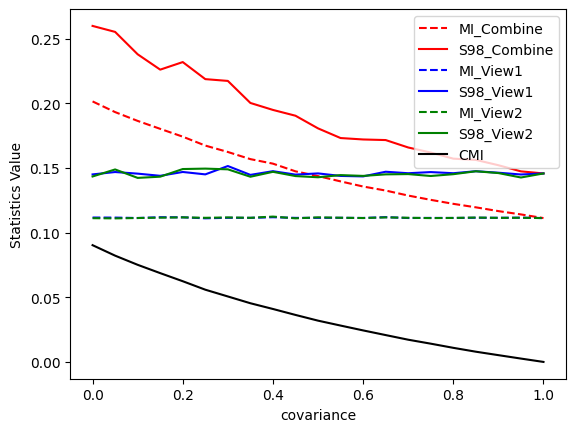

In [8]:
plt.plot(np.arange(0,1.05,0.05),Statistics[0,:],label = 'MI_Combine',color = 'r',linestyle = '--')
plt.plot(np.arange(0,1.05,0.05),Statistics[1,:],label = 'S98_Combine',color = 'r')

plt.plot(np.arange(0,1.05,0.05),Statistics[3,:],label = 'MI_View1',color = 'b',linestyle = '--')
plt.plot(np.arange(0,1.05,0.05),Statistics[4,:],label = 'S98_View1',color = 'b')

plt.plot(np.arange(0,1.05,0.05),Statistics[6,:],label = 'MI_View2',color = 'g',linestyle = '--')
plt.plot(np.arange(0,1.05,0.05),Statistics[7,:],label = 'S98_View2',color = 'g')

plt.plot(np.arange(0,1.05,0.05),Statistics[9,:],label = 'CMI',color = 'black')

plt.xlabel('covariance')
plt.ylabel('Statistics Value')

plt.legend()